### Generate Insight into the correlation between Error- and UQ Maps of the reconstruction (R1 vs R3 or R6)


In [17]:
import sqlite3
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

PAT_IDS     = [
    '0003_ANON5046358',
    '0004_ANON9616598',
    '0005_ANON8290811',
    '0006_ANON2379607',
    '0007_ANON1586301',
    '0008_ANON8890538',
    '0010_ANON7748752',
    '0011_ANON1102778',
    '0012_ANON4982869',
    '0013_ANON7362087',
    '0014_ANON3951049',
    '0015_ANON9844606',
    '0018_ANON9843837',
    '0019_ANON7657657',
    '0020_ANON1562419',
    '0021_ANON4277586',
    '0023_ANON6964611',
    '0024_ANON7992094',
    '0026_ANON3620419',
    '0027_ANON9724912',
    '0028_ANON3394777',
    '0029_ANON7189994',
    '0030_ANON3397001',
    '0031_ANON9141039',
    '0032_ANON7649583',
    '0033_ANON9728185',
    '0035_ANON3474225',
    '0036_ANON0282755',
    '0037_ANON0369080',
    '0039_ANON0604912',
    '0042_ANON9423619',
    '0043_ANON7041133',
    '0044_ANON8232550',
    '0045_ANON2563804',
    '0047_ANON3613611',
    '0048_ANON6365688',
    '0049_ANON9783006',
    '0051_ANON1327674',
    '0052_ANON9710044',
    '0053_ANON5517301',
    '0055_ANON3357872',
    '0056_ANON2124757',
    '0057_ANON1070291',
    '0058_ANON9719981',
    '0059_ANON7955208',
    '0061_ANON7642254',
    '0062_ANON0319974',
    '0063_ANON9972960',
    '0064_ANON0282398',
    '0067_ANON0913099',
    '0068_ANON7978458',
    '0069_ANON9840567',
    '0070_ANON5223499',
    '0071_ANON9806291',
    '0073_ANON5954143',
    '0075_ANON5895496',
    '0076_ANON3983890',
    '0077_ANON8634437',
    '0078_ANON6883869',
    '0079_ANON8828023',
    '0080_ANON4499321',
    '0081_ANON9763928',
    '0082_ANON6073234',
    '0083_ANON9898497',
    '0084_ANON6141178',
    '0085_ANON4535412',
    '0086_ANON8511628',
    '0087_ANON9534873',
    '0088_ANON9892116',
    '0089_ANON9786899',
    '0090_ANON0891692',
    '0092_ANON9941969',
    '0093_ANON9728761',
    '0094_ANON8024204',
    '0095_ANON4189062',
    '0097_ANON5642073',
    '0103_ANON8583296',
    '0104_ANON7748630',
    '0105_ANON9883201',
    '0107_ANON4035085',
    '0108_ANON0424679',
    '0109_ANON9816976',
    '0110_ANON8266491',
    '0111_ANON9310466',
    '0112_ANON3210850',
    '0113_ANON9665113',
    '0115_ANON0400743',
    '0116_ANON9223478',
    # '0118_ANON7141024',
    '0119_ANON3865800',
    '0120_ANON7275574',
    '0121_ANON9629161',
    '0123_ANON7265874',
    '0124_ANON8610762',
    '0125_ANON0272089',
    '0126_ANON4747182',
    '0127_ANON8023509',
    '0128_ANON8627051',
    '0129_ANON5344332',
    '0135_ANON9879440',
    '0136_ANON8096961',
    '0137_ANON8035619',
    '0138_ANON1747790',
    '0139_ANON2666319',
    '0140_ANON0899488',
    '0141_ANON8018038',
    '0142_ANON7090827',
    '0143_ANON9752849',
    '0144_ANON2255419',
    '0145_ANON0335209',
    '0146_ANON7414571',
    '0148_ANON9604223',
    '0149_ANON4712664',
    '0150_ANON5824292',
    '0152_ANON2411221',
    '0153_ANON5958718',
    '0155_ANON7828652',
    '0157_ANON9873056',
    '0159_ANON9720717',
    '0160_ANON3504149'
]

REGIONS     = ["slice", "prostate", "lesion"]
ACC_LEVELS  = [3, 6]
METHOD_MAP  = {"gaussian": "GN-MC", "lxo": "ET-Drop"}

# === Configurable Parameters ===
DB_FPATH  = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db')
TABLE     = "uq_vs_error_correlation_std"  # or remove _debug if running final
FIGDIR    = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures')
VERBOSE   = True


# === SQLite DB Utilities ===

def connect_db(db_path: Path) -> sqlite3.Connection:
    """Establish and return SQLite connection."""
    return sqlite3.connect(str(db_path))

def run_query(conn: sqlite3.Connection, query: str) -> pd.DataFrame:
    """Execute a SQL query and return the result as a DataFrame."""
    return pd.read_sql_query(query, conn)

def preview_table(conn: sqlite3.Connection, table_name: str, n: int = 5):
    """Print the first n rows of the specified table."""
    df = run_query(conn, f"SELECT * FROM {table_name} LIMIT {n};")
    display(df)

# === Establish Connection ===
conn = connect_db(DB_FPATH)

# === Preview Table (Optional) ===
if VERBOSE:
    print(f"🔍 Preview of '{TABLE}' table:")
    preview_table(conn, TABLE)

🔍 Preview of 'uq_vs_error_correlation_std' table:


,pat_id,slice_idx,acc_factor,uq_method,region,mean_abs,mean_uq,std_uq,pearson_corr,spearman_corr
0,0003_ANON5046358,0,3,gaussian,slice,8.835545,0.000991,0.000257,0.367489,0.374207
1,0003_ANON5046358,1,3,gaussian,slice,9.663578,0.001003,0.000257,0.413001,0.388464
2,0003_ANON5046358,2,3,gaussian,slice,8.432629,0.001011,0.000259,0.392491,0.368357
3,0003_ANON5046358,3,3,gaussian,slice,8.865566,0.001011,0.000253,0.339506,0.329187
4,0003_ANON5046358,4,3,gaussian,slice,9.475834,0.001019,0.000259,0.414462,0.417164


In [3]:
# --- Pull all slice-level correlations including region ---
query = f"""
SELECT pat_id, uq_method, acc_factor, region, spearman_corr
FROM {TABLE}
WHERE spearman_corr IS NOT NULL;
"""
correlation_data = run_query(conn, query)

correlation_data.head()

new_col_names = {
    "pat_id": "Patient ID",
    "uq_method": "UQ Method",
    "acc_factor": "R",
    "region": "Region",
    "spearman_corr": "Correlation"
}
correlation_data.rename(columns=new_col_names, inplace=True)

correlation_data.head()


,Patient ID,UQ Method,R,Region,Correlation
0,0003_ANON5046358,gaussian,3,slice,0.374207
1,0003_ANON5046358,gaussian,3,slice,0.388464
2,0003_ANON5046358,gaussian,3,slice,0.368357
3,0003_ANON5046358,gaussian,3,slice,0.329187
4,0003_ANON5046358,gaussian,3,slice,0.417164


# Wilcox test

In [4]:

df = correlation_data.copy()

# --- 1. Harmonise labels (overwrite) ---------------------------------------
df["UQ Method"] = df["UQ Method"].replace(METHOD_MAP)
df = df[df.R.isin(ACC_LEVELS)]

# --- 2. Patient-level median ----------------------------------------------
df_pat = (df.groupby(["Patient ID", "R", "UQ Method", "Region"], as_index=False)
            .Correlation.median())

# --- 3. Paired Wilcoxon ----------------------------------------------------
rows = []
for R in ACC_LEVELS:
    for reg in REGIONS:
        sub  = df_pat.query("R == @R and Region == @reg")
        wide = sub.pivot(index="Patient ID",
                         columns="UQ Method",
                         values="Correlation").dropna()

        if {"GN-MC", "ET-Drop"}.issubset(wide.columns):
            stat, p = wilcoxon(wide["GN-MC"], wide["ET-Drop"])
            rows.append({"R": R, "region": reg, "n": len(wide),
                         "W": stat, "p_value": p})
        else:
            rows.append({"R": R, "region": reg, "n": len(wide),
                         "W": None, "p_value": None})

wilcox_table = pd.DataFrame(rows)

# add significance stars
def add_sig_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.010:
        return '**'
    elif p < 0.050:
        return '*'
    else:
        return 'ns'

wilcox_table = wilcox_table.copy()
wilcox_table["sig"] = wilcox_table.p_value.apply(add_sig_star)

print(wilcox_table)


   R    region    n       W       p_value  sig
0  3     slice  119  1169.0  1.927634e-10  ***
1  3  prostate  118  2639.0  1.926469e-02    *
2  3    lesion   36   291.0  5.189233e-01   ns
3  6     slice  119  1026.0  1.517599e-11  ***
4  6  prostate  119   777.0  1.296683e-13  ***
5  6    lesion   36   238.0  1.389850e-01   ns


# Visualises difference between UQ methods for each (R, region) and prints basic symmetry stats.

R=3, Region=slice:  mean=-0.037, median=-0.036, n=119
R=3, Region=prostate:  mean=-0.009, median=-0.009, n=118
R=3, Region=lesion:  mean=-0.029, median=0.003, n=36
R=6, Region=slice:  mean=0.042, median=0.045, n=119
R=6, Region=prostate:  mean=0.045, median=0.042, n=119
R=6, Region=lesion:  mean=0.020, median=0.068, n=36


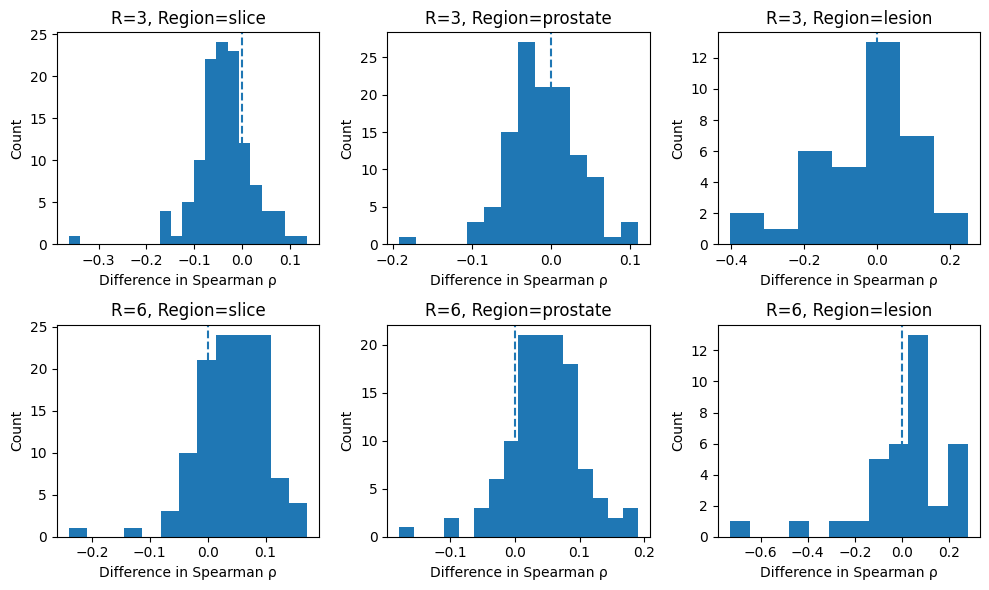

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for idx, (R, reg) in enumerate([(R, reg) for R in ACC_LEVELS for reg in REGIONS]):
    sub = df_pat.query("R == @R and Region == @reg")
    wide = sub.pivot(index="Patient ID", columns="UQ Method", values="Correlation").dropna()
    diff = wide["GN-MC"] - wide["ET-Drop"]

    ax = axes[idx]
    ax.hist(diff, bins="auto")          # NO explicit colour
    ax.axvline(0, linestyle="--")       # reference at zero
    ax.set_title(f"R={R}, Region={reg}")
    ax.set_xlabel("Difference in Spearman ρ")
    ax.set_ylabel("Count")

    # Symmetry summary
    print(f"R={R}, Region={reg}:  mean={diff.mean():.3f}, median={np.median(diff):.3f}, n={len(diff)}")

# Adjust layout
plt.tight_layout()
plt.show()


# Figure 1 v2 - Boxplot per acceleration, region and UQ method

/tmp/ipykernel_3140719/1738837315.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.capitalize() for t in order_regions])
/tmp/ipykernel_3140719/1738837315.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.capitalize() for t in order_regions])


Figure saved → /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures/spearman_violin_v1.png


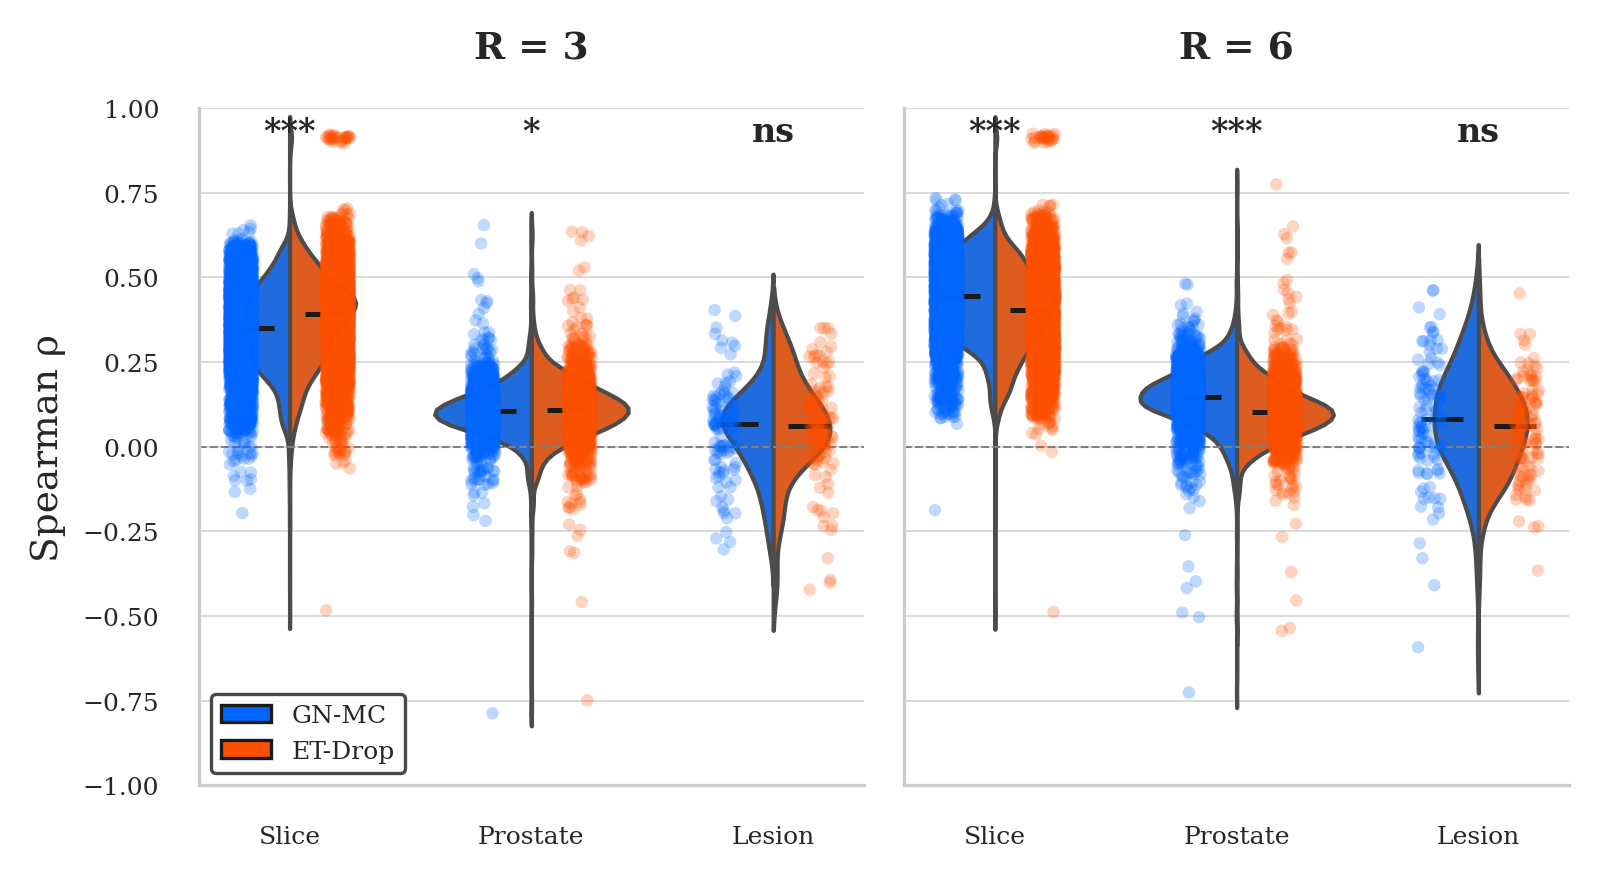

In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# Plot Spearman violin (slice-level dots) with Wilcoxon significance stars
# ────────────────────────────────────────────────────────────────────────────
from pathlib import Path
import matplotlib as mpl, matplotlib.pyplot as plt
import pandas as pd, seaborn as sns
from matplotlib.patches import Patch

def plot_spearman_violin_v1(df: pd.DataFrame,
                            wilcox_table: pd.DataFrame,
                            out="figures/spearman_violin_v1.png"):
    """
    Parameters
    ----------
    df : DataFrame
        Must contain columns:  Patient ID | R | UQ Method | Region | Correlation
    wilcox_table : DataFrame
        Columns required: R | region | sig
        sig should be one of '***', '**', '*', 'ns'
    out : str or Path
        Output PNG path.
    """

    # ---------------- global style ------------------------------------------
    mpl.rcParams.update({
        # text & fonts
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 9,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "legend.fontsize": 6,
        "legend.title_fontsize": 7,
        # lines & grid
        "axes.linewidth": 0.8,
        "grid.color": "#C0C0C0",
        "grid.linewidth": 0.4,
        "patch.linewidth": 0.8,
        "lines.markersize": 3,
        # spines
        "axes.spines.top": False,
        "axes.spines.right": False,
        # dpi
        "figure.dpi": 300,
        "savefig.dpi": 600,
    })

    # ----- tidy labels ------------------------------------------------------
    df = df.copy()
    df["R_num"] = (df["R"].astype(int)
                   if pd.api.types.is_numeric_dtype(df["R"])
                   else df["R"].str.extract(r"(\d+)").astype(int))
    df = df[df["R_num"].isin([3, 6])]
    df["R_label"] = df["R_num"].map({3: "R = 3", 6: "R = 6"})
    df["UQ Method"] = df["UQ Method"].map({"gaussian": "GN-MC", "lxo": "ET-Drop"})

    order_regions = ["slice", "prostate", "lesion"]
    palette = ["#0066FF", "#FD5000"]  # blue / red

    # ---------------- figure & axes -----------------------------------------
    g = sns.catplot(
        data=df, x="Region", y="Correlation",
        hue="UQ Method", col="R_label",
        col_order=["R = 3", "R = 6"],
        kind="violin", split=True, inner=None,
        order=order_regions, palette=palette,
        height=3.0, aspect=.9, sharey=True, legend=False
    )
    g.set_titles("{col_name}", pad=12, fontweight="bold")

    # loop over facets
    for col_label, ax in zip(g.col_names, g.axes.flat):
        sub = df[df["R_label"] == col_label]

        sns.stripplot(
            data=sub, x="Region", y="Correlation",
            hue="UQ Method", dodge=True,
            marker="o", size=3, alpha=.25,
            palette=palette, order=order_regions,
            legend=False, ax=ax
        )

        # median bars
        med = sub.groupby(["Region", "UQ Method"])["Correlation"].median()
        for (reg, mth), val in med.items():
            offset = -0.15 if mth == "GN-MC" else 0.15
            ax.plot(order_regions.index(reg) + offset, val,
                    "k_", ms=10, mew=1.2)

        # significance stars -------------------------------------------------
        R_num = int(col_label.split()[-1])          # extract 3 or 6 from 'R = 3'
        for xpos, reg in enumerate(order_regions):
            try:
                star = (wilcox_table
                        .query("R == @R_num and region == @reg")
                        .sig.values[0])
            except IndexError:
                star = "ns"
            ax.text(xpos, 0.93, star,
                    ha="center", va="center",
                    fontsize=8, fontweight="bold")

        # cosmetics
        ax.set_xlabel("")
        ax.set_ylabel("Spearman ρ" if R_num == 3 else "")
        ax.set_ylim(-1, 1)
        ax.set_xticklabels([t.capitalize() for t in order_regions])
        ax.axhline(0, ls="--", lw=.5, color="grey")
        ax.grid(axis="y", linestyle="-", alpha=.7)

    # legend
    handles = [Patch(fc=palette[0], ec="k", label="GN-MC"),
               Patch(fc=palette[1], ec="k", label="ET-Drop")]
    g.axes[0][0].legend(handles=handles, loc="lower left",
                        frameon=True, edgecolor="k")

    # save
    g.fig.tight_layout()
    out = Path(out)
    out.parent.mkdir(parents=True, exist_ok=True)
    g.fig.savefig(out, dpi=600, bbox_inches="tight")
    print(f"Figure saved → {out}")

# ────────────────────────────────────────────────────────────────────────────
# Example call
# ────────────────────────────────────────────────────────────────────────────
# correlation_data  : your full slice-wise dataframe
# wilcox_table      : DataFrame with R | region | sig  (see earlier cell)

plot_spearman_violin_v1(correlation_data,
                        wilcox_table,
                        out = FIGDIR / Path("spearman_violin_v1.png"))

# Plot abs error vs UQ for each voxel for 1 patient.

In [10]:
SEQ_ID = '0007'

# --- Pull all slice-level correlations including region ---
query = f"""
SELECT
    pat_id,
    uq_method,
    acc_factor,
    region,
    spearman_corr
FROM {TABLE}
WHERE
    spearman_corr IS NOT NULL
    AND
    pat_id like '%{SEQ_ID}%';
"""
pat_df = run_query(conn, query)
pat_df.head()
new_col_names = {
    "pat_id": "Patient ID",
    "uq_method": "UQ Method",
    "acc_factor": "R",
    "region": "Region",
    "spearman_corr": "Correlation"
}
pat_df.rename(columns=new_col_names, inplace=True)
pat_df.head()

print("We need the actual voxel values instead of correlation values.")

We need the actual voxel values instead of correlation values.


Processing 0003_ANON5046358…


/tmp/ipykernel_290893/2928542861.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


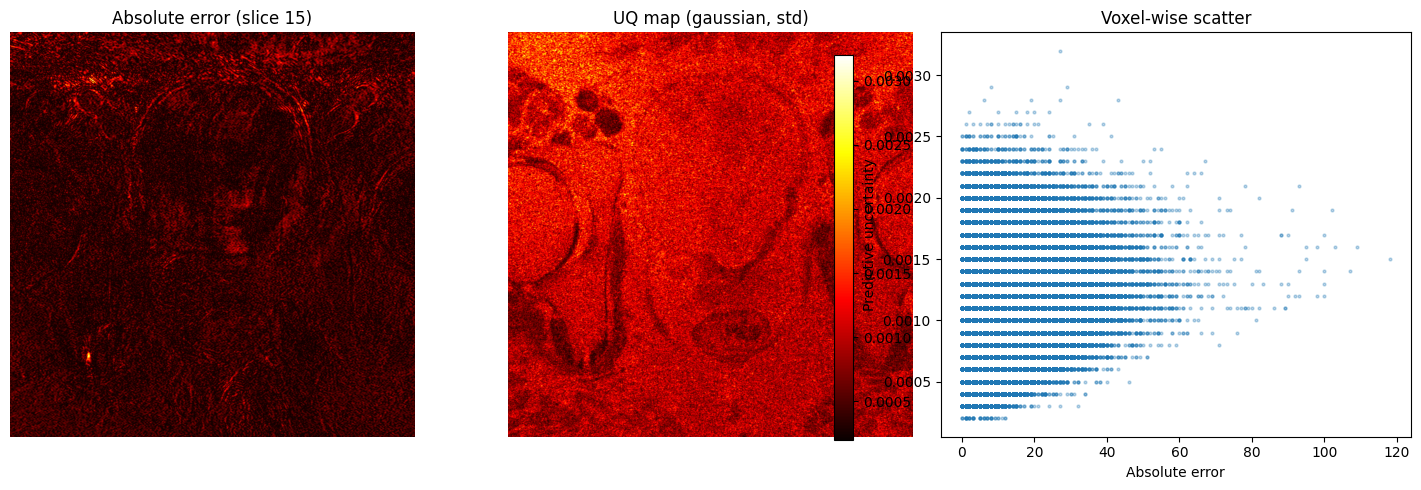

In [19]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

acc        = 3                       # or 6
uq_method  = "gaussian"              # or "lxo"
uq_metric  = "std"                   # or "var", "cv"
pro_root   = Path("/scratch/hb-pca-rad/projects/04_uncertainty_quantification")
rs_root    = Path("/scratch/hb-pca-rad/projects/03_reader_set_v2")

for pat_id in PAT_IDS[0:1]:               # PAT_IDS must be predefined list/iterable
    print(f"Processing {pat_id}…")

    # ---------- Load images ----------
    r1_img = sitk.ReadImage(rs_root / pat_id / f"{pat_id}_rss_target_dcml.mha")
    rx_img = sitk.ReadImage(rs_root / pat_id / f"{pat_id}_VSharp_R{acc}_recon_dcml.mha")
    uq_img = sitk.ReadImage(
        pro_root / uq_method / f"recons_{acc}x" / pat_id /
        f"uq_map_R{acc}_{uq_method}_{uq_metric}.nii.gz"
    )

    r1 = sitk.GetArrayFromImage(r1_img)        # shape = (Z, Y, X)
    rx = sitk.GetArrayFromImage(rx_img)
    uq = sitk.GetArrayFromImage(uq_img)

    # ---------- Sanity check ----------
    assert r1.shape == rx.shape == uq.shape, "Shape mismatch between images"

    # ---------- Absolute-error map ----------
    abs_err = np.abs(r1 - rx)                  # keep full 3-D array

    # ---------- Choose a representative slice ----------
    z = r1.shape[0] // 2                       # mid-gland slice
    ref_slice  = r1[z]
    err_slice  = abs_err[z]
    uq_slice   = uq[z]

    # ---------- Plot ----------
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(err_slice, cmap="hot")
    axes[0].set_title(f"Absolute error (slice {z})")
    axes[0].axis("off")

    im = axes[1].imshow(uq_slice, cmap="hot")
    axes[1].set_title(f"UQ map ({uq_method}, {uq_metric})")
    axes[1].axis("off")

    # scatter of all voxels in this slice
    axes[2].scatter(err_slice.flatten(), uq_slice.flatten(),
                    s=4, alpha=0.3)
    axes[2].set_xlabel("Absolute error")
    axes[2].set_ylabel("Predictive uncertainty")
    axes[2].set_title("Voxel-wise scatter")

    plt.colorbar(im, ax=axes[:2], fraction=0.046, pad=0.04)
    fig.tight_layout()

    out_png = FIGDIR / f"{pat_id}_R{acc}_{uq_method}_{uq_metric}.png"
    fig.savefig(out_png, dpi=300)
    plt.show()
    plt.close(fig)        # prevent memory leak in loops

In [ ]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# -------------------- configuration --------------------
acc        = 3                        # or 6
uq_method  = "gaussian"              # or "lxo"
uq_metric  = "std"                   # 'var' or 'cv' if desired
pat_id     = "0003_ANON5046358"      # choose one
pro_root   = Path("/scratch/hb-pca-rad/projects/04_uncertainty_quantification")
rs_root    = Path("/scratch/hb-pca-rad/projects/03_reader_set_v2")
fig_dir    = Path("./fig_error_uq"); fig_dir.mkdir(exist_ok=True)

# -------------------- load volumes --------------------
r1_img = sitk.ReadImage(rs_root / pat_id / f"{pat_id}_rss_target_dcml.mha")
rx_img = sitk.ReadImage(rs_root / pat_id / f"{pat_id}_VSharp_R{acc}_recon_dcml.mha")
uq_img = sitk.ReadImage(
    pro_root / uq_method / f"recons_{acc}x" / pat_id /
    f"uq_map_R{acc}_{uq_method}_{uq_metric}.nii.gz"
)

r1 = sitk.GetArrayFromImage(r1_img).astype(np.float32)
rx = sitk.GetArrayFromImage(rx_img).astype(np.float32)
uq = sitk.GetArrayFromImage(uq_img).astype(np.float32)

assert r1.shape == rx.shape == uq.shape, "shape mismatch"

# -------------------- common normalisation --------------------
# use 95th percentile of reference volume
s = np.percentile(r1, 95)
r1 /= s; rx /= s; uq /= s           # inplace scale

# -------------------- compute absolute error ------------------
abs_err = np.abs(r1 - rx)

# -------------------- flatten all voxels ----------------------
abs_vec = abs_err.flatten()
uq_vec  = uq.flatten()

# Option A ---------- full hexbin (recommended) ---------------
fig, ax = plt.subplots(figsize=(5,4))
hb = ax.hexbin(abs_vec, uq_vec, gridsize=100, bins='log', mincnt=10)
ax.plot([0, np.max(abs_vec)], [0, np.max(abs_vec)], 'k--', lw=1)
ax.set_xlabel("Absolute error")
ax.set_ylabel("Predictive uncertainty (σ)")
ax.set_title(f"{pat_id}  •  R={acc}  •  {uq_method.upper()}")

cb = fig.colorbar(hb, ax=ax)
cb.set_label("log\u2081\u2080 voxel count")

fig.tight_layout()
fig.savefig(FIGDIR / f"{pat_id}_R{acc}_{uq_method}_hexbin.png", dpi=300)
plt.close(fig)


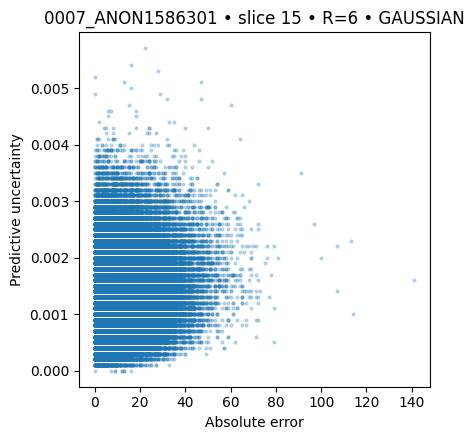

In [33]:
# ---------- Simple voxel-scatter plot (one patient, mid-slice) ----------
# Requirements: SimpleITK, NumPy, Matplotlib
# What it does : loads reference, reconstruction, and uncertainty map;
#                computes absolute-error map; plots voxel-wise scatter
#                for the middle slice (no calibration, raw units).

from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------ CONFIG --------------------------------
pat_id    = PAT_IDS[4]   # <- change to your patient folder
acc       = 6                    # 3 or 6
uq_method = "gaussian"           # "gaussian" or "lxo"
uq_metric = "std"                # 'std', 'var', 'cv'
z         = 15

rs_root  = Path("/scratch/hb-pca-rad/projects/03_reader_set_v2")
pro_root = Path("/scratch/hb-pca-rad/projects/04_uncertainty_quantification")
fig_dir  = Path("./fig_error_uq"); fig_dir.mkdir(exist_ok=True)

# --------------------------- LOAD VOLUMES ------------------------------
def read_float(path):
    img = sitk.ReadImage(path)
    return sitk.GetArrayFromImage(img).astype(np.float32)

r1 = read_float(rs_root / pat_id / f"{pat_id}_rss_target_dcml.mha")
rx = read_float(rs_root / pat_id / f"{pat_id}_VSharp_R{acc}_recon_dcml.mha")
uq = read_float(
        pro_root / uq_method / f"recons_{acc}x" / pat_id /
        f"uq_map_R{acc}_{uq_method}_{uq_metric}.nii.gz"
     )

# scale = np.percentile(r1, 95)   # same factor used in training
# r1 /= scale
# rx /= scale

assert r1.shape == rx.shape == uq.shape, "Shape mismatch in volumes"

# ---------------------- COMPUTE ABSOLUTE ERROR ------------------------
abs_err = np.abs(r1 - rx)

# ------------------------------ PLOT ----------------------------------
fig, ax = plt.subplots(figsize=(4.5, 4.5))

ax.scatter(abs_err[z].ravel(),   # x-axis: error (raw a.u.)
           uq[z].ravel(),        # y-axis: σ (normalised units)
           s=4, alpha=0.25, c="tab:blue")

ax.set_xlabel("Absolute error")
ax.set_ylabel("Predictive uncertainty")
ax.set_title(f"{pat_id} • slice {z} • R={acc} • {uq_method.upper()}")

fig.tight_layout()
out_png = FIGDIR / f"{pat_id}_R{acc}_{uq_method}_slice{z}.png"
fig.savefig(out_png, dpi=300)
plt.show()


# Lets make a table with Acceleration, Method, Region, median_correlation


In [ ]:
def get_cor_df():
    query = f"""
    SELECT pat_id, uq_method, acc_factor, region, spearman_corr
    FROM {TABLE}
    WHERE spearman_corr IS NOT NULL;
    """
    correlation_data = run_query(conn, query)
    new_col_names = {
        "pat_id": "Patient ID",
        "uq_method": "UQ Method",
        "acc_factor": "R",
        "region": "Region",
        "spearman_corr": "Correlation"
    }
    correlation_data.rename(columns=new_col_names, inplace=True)
    print(correlation_data.head())
    return correlation_data



import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# -----------------------------------------------------------------------------
# correlation_data columns expected after rename:
#   "Patient ID" | "UQ Method" | "R" | "Region" | "Correlation"
# -----------------------------------------------------------------------------

# 1. ------------- helper: Cliff’s δ (optional) --------------------------------
def cliffs_delta(x, y):
    """
    Non-parametric effect size:
    δ = (P(x > y) − P(x < y)) / (n_x · n_y)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    m, n = len(x), len(y)
    greater = np.sum(x[:, None] > y)
    less    = np.sum(x[:, None] < y)
    return (greater - less) / float(m * n)

# 2. ------------- summary calculation ----------------------------------------
cor_df = get_cor_df()
rows = []
for R in [3, 6]:
    for region in ["slice", "prostate", "lesion"]:
        subset = correlation_data.query("R == @R and Region == @region")

        gn   = subset.query("`UQ Method` == 'gaussian'")["Correlation"]
        lxo  = subset.query("`UQ Method` == 'lxo'")["Correlation"]

        # ensure paired by patient & slice
        key = ["Patient ID"]
        if "slice_idx" in subset.columns:      # if slice index exists
            key.append("slice_idx")

        paired = (subset[key + ["UQ Method", "Correlation"]]
                  .pivot_table(index=key, columns="UQ Method",
                               values="Correlation")
                  .dropna())

        gn_vec  = paired["gaussian"]
        lxo_vec = paired["lxo"]

        # signed-rank test (needs ≥1 pair)
        if len(paired) > 0:
            W, p = wilcoxon(gn_vec, lxo_vec, zero_method="wilcox")
        else:
            p = np.nan

        # store stats for each method
        for label, vec in [("GN-MC", gn), ("ET-Drop", lxo)]:
            med = vec.median()
            q1, q3 = vec.quantile([0.25, 0.75])
            rows.append({
                "R": R,
                "Region": region.title(),
                "Method": label,
                "Median": round(med, 2),
                "IQR": f"[{q1:.2f}–{q3:.2f}]",
                "N": len(vec),
                "Wilcoxon p": f"{p:.3e}" if label == "ET-Drop" else "",
                "Cliff's δ": f"{cliffs_delta(gn_vec, lxo_vec):.2f}"
                              if label == "ET-Drop" else ""
            })

summary_df = pd.DataFrame(rows)
print(summary_df.to_markdown(index=False))
summary_df.to_csv("spearman_summary.csv", index=False)

         Patient ID UQ Method  R Region  Correlation
0  0003_ANON5046358  gaussian  3  slice     0.374207
1  0003_ANON5046358  gaussian  3  slice     0.388464
2  0003_ANON5046358  gaussian  3  slice     0.368357
3  0003_ANON5046358  gaussian  3  slice     0.329187
4  0003_ANON5046358  gaussian  3  slice     0.417164
|   R | Region   | Method   |   Median | IQR            |    N | Wilcoxon p   | Cliff's δ   |
|----:|:---------|:---------|---------:|:---------------|-----:|:-------------|:------------|
|   3 | Slice    | GN-MC    |     0.35 | [0.257–0.438]  | 3908 |              |             |
|   3 | Slice    | ET-Drop  |     0.39 | [0.288–0.465]  | 3873 | 3.515e-10    | -0.18       |
|   3 | Prostate | GN-MC    |     0.1  | [0.062–0.146]  | 1486 |              |             |
|   3 | Prostate | ET-Drop  |     0.11 | [0.059–0.165]  | 1474 | 1.979e-01    | -0.02       |
|   3 | Lesion   | GN-MC    |     0.07 | [-0.018–0.129] |  118 |              |             |
|   3 | Lesion   | ET-Dr